In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import cvxpy as cp


In [2]:
N = 5 #number of different assets
correlation_matrix = pd.read_csv('correlation.csv', index_col=0)
moments =  pd.read_csv('moments.csv', index_col=0)
# so columns are moments
moments_t = moments.T

In [3]:
moments

,AAPL,AMZN,NFLX,META,GOOG
Mean,0.044858,0.010362,-0.029675,-0.006934,0.029035
St Dev,0.009320,0.009557,0.013409,0.011582,0.008376
Skew,-0.335173,-0.312865,-3.101654,-1.936506,-0.197700
Kurt,5.034093,4.729806,41.968015,23.289236,4.310171


In [4]:
px.imshow(correlation_matrix.round(3),text_auto=True)

In [5]:
v_mu = moments_t['Mean']
v_std = moments_t['St Dev']

### Calculate covariance matrix from correlation matrix

In [6]:
# Covariance from correlation

#moments.iloc[1]

diag_std = np.diag(v_std)

covariance_matrix= diag_std @ correlation_matrix @ diag_std

covariance_matrix.index = correlation_matrix.index
covariance_matrix.columns = correlation_matrix.columns
covariance_matrix

,AAPL,AMZN,NFLX,META,GOOGL
AAPL,0.000087,0.000059,0.000057,0.000064,0.000055
AMZN,0.000059,0.000091,0.000076,0.000069,0.000054
NFLX,0.000057,0.000076,0.000180,0.000080,0.000055
META,0.000064,0.000069,0.000080,0.000134,0.000065
GOOGL,0.000055,0.000054,0.000055,0.000065,0.000070


In [7]:
def port_var(v_w, M_cov):
    #wT @ cov @ w
    return v_w.T @ M_cov @ v_w
    #np.dot(np.dot(v_w, M_cov), v_w)

def port_mean(v_w, v_mu):
    #weightes mean return
    return np.dot(v_w, v_mu)

def port_sharpe(v_w, v_mu, M_cov):
    return port_mean(v_w, v_mu)/np.sqrt(port_var(v_w, M_cov))

def port_var_for_2_assets(w1, w2, cor12, sd1,sd2):
    return w1**2*sd1**2 + w2**2*sd2**2 + 2*w1*w2*cor12*sd1*sd2

In [8]:
covariance_matrix

,AAPL,AMZN,NFLX,META,GOOGL
AAPL,0.000087,0.000059,0.000057,0.000064,0.000055
AMZN,0.000059,0.000091,0.000076,0.000069,0.000054
NFLX,0.000057,0.000076,0.000180,0.000080,0.000055
META,0.000064,0.000069,0.000080,0.000134,0.000065
GOOGL,0.000055,0.000054,0.000055,0.000065,0.000070


In [9]:
covariance_matrix.iloc[[0,1],[0,1]]

,AAPL,AMZN
AAPL,0.000087,0.000059
AMZN,0.000059,0.000091


In [10]:
v_mu.iloc[[0,1]]

AAPL    0.044858
AMZN    0.010362
Name: Mean, dtype: float64

In [11]:
v_mu.iloc[[1,0]]


AMZN    0.010362
AAPL    0.044858
Name: Mean, dtype: float64

In [12]:
# CASE 1: portfolio with one long position and one short position

# weights for long-short portfolio of 2 stocks, weights should sum to 1 with one being positive and other being negative
from itertools import count


v_w = np.array([1.5, -0.5])

# portfolio variance for long-short portfolio between 2 stocks for all combinations of 2 stocks

# combinations 1,2 1,3 1,4 1,5 2,3 2,4 2,5 3,4 3,5 4,5 

# count number of combinations
port_returns_for2 = np.zeros(shape=(N,N))
port_var_for2 = np.zeros(shape=(N,N))
port_sharpe_for2 = np.zeros(shape=(N,N))
for i in range(N):
    for j in range(N):
        #if i!=j:
            # [i,j]==[j,i]
            # calculate only for i<j
        if i<j:
            sub_cov_matrix = covariance_matrix.iloc[[i,j],[i,j]]
            sub_mu = v_mu.iloc[[i,j]]
            port_var_for2[i,j]= port_var_for2[j,i]= port_var(v_w, sub_cov_matrix)
            #port_var_for2[i,j] = port_var_for_2_assets(v_w[0],v_w[1], cor12=correlation_matrix.iloc[i,j], sd1=v_std.iloc[i], sd2=v_std.iloc[j])
            port_returns_for2[i,j] =port_returns_for2[j,i]= port_mean(v_w, sub_mu)
            port_sharpe_for2[i,j]=port_sharpe_for2[j,i] = port_sharpe(v_w, sub_mu, sub_cov_matrix)
            
            #print('Portfolio variance for long-short portfolio between', i+1, 'and', j+1, 'is', port_var(v_w, sub_cov_matrix))
            #print('Portfolio mean for long-short portfolio between', i+1, 'and', j+1, 'is', port_mean(v_w, sub_mu))
        

### plots

In [18]:

# plot portfolio variance for long-short portfolio between 2 stocks for all combinations of 2 stocks
import plotly.graph_objects as go

"""
fig = go.Figure(data=[go.Surface(z=port_var_for2)])
fig.update_layout(title='Portfolio variance for long-short portfolio between 2 stocks for all combinations of 2 stocks', autosize=False,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90))
fig.show()"""

# plot portfolio mean for long-short portfolio between 2 stocks for all combinations of 2 stocks as heat map
fig = px.imshow(port_returns_for2.round(4),x=correlation_matrix.columns,y=correlation_matrix.columns,text_auto=True)
fig.update_layout(title='Mean for long-short between 2 comp',
                    #width=400, height=400,
                    margin=dict(l=65, r=50, b=65, t=90))
fig.show()
# save figure
fig.write_image("P_A_mean.png")

In [19]:
# plot portfolio variance for long-short portfolio between 2 stocks for all combinations of 2 stocks as heat map
fig = px.imshow(port_var_for2.round(4),x=correlation_matrix.columns,y=correlation_matrix.columns, text_auto=True)
fig.update_layout(title='Variance for long-short between 2 comp',
                    margin=dict(l=65, r=50, b=65, t=90))
fig.show()
# save figure
fig.write_image("P_A_variance.png")

In [20]:
# plot portfolio sharpe for long-short portfolio between 2 stocks for all combinations of 2 stocks as heat map
from turtle import width


fig = px.imshow(port_sharpe_for2.round(4),x=correlation_matrix.columns,y=correlation_matrix.columns, text_auto=True)
fig.update_layout(title='sharpe ratio for long-short between 2 comp',
                    margin=dict(l=65, r=50, b=65, t=90))
fig.show()
# save figure
fig.write_image("P_A_Sharpe.png")

In [211]:
moments

,AAPL,AMZN,NFLX,META,GOOG
Mean,0.044858,0.010362,-0.029675,-0.006934,0.029035
St Dev,0.009320,0.009557,0.013409,0.011582,0.008376
Skew,-0.335173,-0.312865,-3.101654,-1.936506,-0.197700
Kurt,5.034093,4.729806,41.968015,23.289236,4.310171


In [212]:
correlation_matrix

,AAPL,AMZN,NFLX,META,GOOGL
AAPL,1.000000,0.660739,0.460041,0.594785,0.698431
AMZN,0.660739,1.000000,0.593812,0.626198,0.679323
NFLX,0.460041,0.593812,1.000000,0.515892,0.492697
META,0.594785,0.626198,0.515892,1.000000,0.668024
GOOGL,0.698431,0.679323,0.492697,0.668024,1.000000


### Eigen values and vectors of correlation matrix

In [213]:
# calculate eigen values and eigen vectors
eigen_values, eigen_vectors = np.linalg.eig(correlation_matrix)
print(f'{correlation_matrix.columns}\n Eigen values: {eigen_values}\n Eigen vectors: {eigen_vectors}')

Index(['AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL'], dtype='object')
 Eigen values: [3.40697811 0.59483061 0.40826924 0.28273162 0.30719042]
 Eigen vectors: [[-0.45103522 -0.39079718 -0.47508612  0.43045949  0.48253766]
 [-0.46989172  0.06847317 -0.27789485  0.17772322 -0.8159057 ]
 [-0.39410904  0.85585301 -0.09050444 -0.08466835  0.31118146]
 [-0.44821456 -0.10046606  0.8297825   0.31495687  0.03568544]
 [-0.46856245 -0.31624545  0.01837339 -0.8226497   0.05786142]]


In [214]:
# plot eigen vectors in a line plot with 'AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL' as names for each line
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=correlation_matrix.columns, y=eigen_vectors[:,0], name=f'AAPL_{str(eigen_values[0])}'))
fig.add_trace(go.Scatter(x=correlation_matrix.columns, y=eigen_vectors[:,1], name=f'AMZN_{str(eigen_values[1])}'))
fig.add_trace(go.Scatter(x=correlation_matrix.columns, y=eigen_vectors[:,2], name=f'NFLX_{str(eigen_values[2])}'))
fig.add_trace(go.Scatter(x=correlation_matrix.columns, y=eigen_vectors[:,3], name=f'META_{str(eigen_values[3])}'))
fig.add_trace(go.Scatter(x=correlation_matrix.columns, y=eigen_vectors[:,4], name=f'GOOGL_{str(eigen_values[4])}'))


#fig.update_yaxes(type="log")
fig.update_layout(title='Eigen Vectors', xaxis_title='eigen vectors', yaxis_title='Value')
fig.show()


In [215]:
# plot covariance matrix with jest colormap
fig = px.imshow(covariance_matrix,text_auto=True)
fig.show()
#px.imshow(covariance_matrix)


## portfolio optimization for 2 stocks


In [216]:
sub_mu = v_mu.iloc[[0,1]]
sub_mu

AAPL    0.044858
AMZN    0.010362
Name: Mean, dtype: float64

In [217]:
# objectives for port optimization
# maximize portfolio return mean

from turtle import shape


for i in range(N):
    for j in range(N):
        if i!=j:
            # [i,j]==[j,i]
            # calculate only for i<j
            if i<j:
                #print(i,j)
                sub_cov_matrix = covariance_matrix.iloc[[i,j],[i,j]]
                sub_mu = v_mu.iloc[[i,j]]
                sub_mu = sub_mu.to_numpy().squeeze()
                w = cp.Variable((2,1))

                port_ret = sub_mu.T @ w
                # minimize portfolio volatility
                port_var = cp.quad_form(w, sub_cov_matrix)

                # constraints for port optimization
                # weights should sum to 1
                constraints = [port_ret==1]
                #constraints = [cp.norm1(w) <= 1.5,cp.sum(w)==1.0]

                # problem to optimize , minimize portfolio volatility and maximize portfolio return
                prob = cp.Problem(cp.Minimize(port_var), constraints)
                #prob = cp.Problem(cp.Maximize(port_ret), constraints)


                prob.solve(cp.SCS, verbose=False)
                wts = [float('%0.4f' % v) for v in w.value]
                #wts = np.array(wts)*5
                print(correlation_matrix.columns[i], correlation_matrix.columns[j])
                print(f'Optimal Returns:{np.round(sub_mu.T @ wts,decimals=4)}, weights:{np.array(wts)/sum(wts)} sharpe:{np.round(sub_mu.T @ wts,decimals=4)/np.sqrt(port_var.value[0][0])}')
                #print(np.array(wts)/sum(wts))

                minvol = port_var.value

AAPL AMZN
Optimal Returns:1.0, weights:[ 1.99584145 -0.99584145] sharpe:5.564102130399382
AAPL NFLX
Optimal Returns:1.0, weights:[ 2.11755434 -1.11755434] sharpe:6.930024029427906
AAPL META
Optimal Returns:1.0, weights:[ 2.16867076 -1.16867076] sharpe:6.4577982376678245


c:\Users\saite\Desktop\projects\scripts\.venv\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



AAPL GOOGL
Optimal Returns:1.0, weights:[0.95337345 0.04662655] sharpe:4.815110194084832
AMZN NFLX
Optimal Returns:1.0083, weights:[ 6.64446789 -5.64446789] sharpe:3.7127143383961534
AMZN META
Optimal Returns:1.0, weights:[ 3.60379919 -2.60379919] sharpe:1.964975023199008
AMZN GOOGL
Optimal Returns:1.0, weights:[-0.68897306  1.68897306] sharpe:3.8749487978194725
NFLX META
Optimal Returns:0.9725, weights:[ 1.49275691 -0.49275691] sharpe:2.3021327347905363
NFLX GOOGL
Optimal Returns:1.0, weights:[-1.16208567  2.16208567] sharpe:5.685093340065527
META GOOGL
Optimal Returns:1.0001, weights:[-1.19832803  2.19832803] sharpe:5.230246049928834


## port optimization

## Objectives for N assets
1. port mean \
$ \sum\limits _{i=1} ^N \mu_i * w_i$
2. port variance - Quad form (W^T * C * W)\
$ \sigma_p=\sqrt {w^TCw}$


In [218]:
# l1 norm of weights using numpy
new_v_w = np.array([1.25, -0.25])
l1_norm = np.linalg.norm(v_w, ord=1)
l1_norm

2.8

In [219]:
v_mu = np.reshape(v_mu.to_numpy(), (N,1)).squeeze()

## optimal returns

In [220]:
# objectives for port optimization
# maximize portfolio return mean

w = cp.Variable((N,1))

port_ret = v_mu.T @ w
# minimize portfolio volatility
port_var = cp.quad_form(w, covariance_matrix)

# constraints for port optimization
# weights should sum to 1
constraints = [port_ret==1]

# problem to optimize , minimize portfolio volatility and maximize portfolio return
prob = cp.Problem(cp.Minimize(port_var), constraints)

prob.solve(cp.SCS, verbose=False)
wts = [float('%0.4f' % v) for v in w.value]
print(np.array(wts)/sum(wts))

minvol = port_var.value
print(correlation_matrix.columns)

[ 1.72562384 -0.23376205 -0.76560816 -0.95354989  1.22729626]
Index(['AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL'], dtype='object')


In [221]:
opt_return = v_mu.T @ (np.array(wts)/sum(wts))
opt_return

0.13995188940335604

## varying from min volatility to max volatility appraoch

### min variance/volatility

In [222]:
# objectives for port optimization
# maximize portfolio return mean

w = cp.Variable((N,1))

port_ret = v_mu.T @ w
# minimize portfolio volatility
port_var = cp.quad_form(w, covariance_matrix)

# constraints for port optimization
# weights should sum to 1
constraints = [cp.sum(w) == 1]

# problem to optimize , minimize portfolio volatility and maximize portfolio return
prob = cp.Problem(cp.Minimize(port_var), constraints)

prob.solve(cp.SCS, verbose=False)
wts = [float('%0.4f' % v) for v in w.value]
print(wts)

minvol = port_var.value
print(correlation_matrix.columns)

[0.2436, 0.2013, 0.0322, -0.0451, 0.5679]
Index(['AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL'], dtype='object')


### max return/

In [223]:
# Solve max return portfolio (corner solution)

w = cp.Variable((N,1))

port_ret = v_mu.T @ w
# minimize portfolio volatility
port_var = cp.quad_form(w, covariance_matrix)

# constraints for port optimization
# weights should sum to 1
constraints = [cp.norm1(w) <= 1.2, cp.sum(w) == 1]

prob = cp.Problem(cp.Maximize(port_ret), constraints) # maximize portfolio return
prob.solve(cp.SCS, verbose=False)
#wts = [float('%0.4f' % v) for v in maxret_w.value]
print([float('%0.4f' % v) for v in w.value])
print(correlation_matrix.columns)
maxretvol = port_var.value

[1.1, -0.0, -0.1, -0.0, 0.0]
Index(['AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL'], dtype='object')


## varying

In [224]:
# Solve max return portfolio (corner solution)
var_limit = cp.Parameter(shape=(1,1),nonneg=True)

w = cp.Variable((N,1))

port_ret = v_mu.T @ w
# minimize portfolio volatility
port_var = cp.quad_form(w, covariance_matrix)

# constraints for port optimization
# weights should sum to 1
constraints = [cp.norm1(w) <= 1.5,cp.sum(w) == 1, port_var <= var_limit]
prob = cp.Problem(cp.Maximize(port_ret), constraints) # maximize portfolio return


def solve_vl(var_val):
    var_limit.value = np.reshape(var_val,(1,1))
    #prob.solve(cp.SCS, verbose=False)
    #return [float('%0.4f' % v) for v in w.value]
    #(port_ret.value, np.sqrt(port_var.value), [float('%0.4f' % v) for v in w.value])
    result = prob.solve(cp.SCS, verbose=False)
    return (port_ret.value, np.sqrt(port_var.value), w.value)


# number of points on the frontier
NPOINTS = 20
var_vals = np.linspace(minvol, maxretvol, NPOINTS)


print(correlation_matrix.columns)

# iterate in-process
results_dict = {}
mean_return=[]
volatility=[]
for var_val in var_vals:
    results_dict[str(var_val)] = solve_vl(var_val)
    mean_return.extend(results_dict[str(var_val)][0])
    volatility.extend(results_dict[str(var_val)][1][0])

Index(['AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL'], dtype='object')


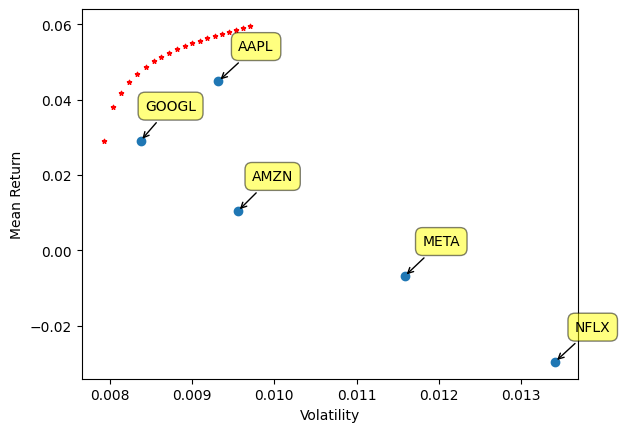

In [225]:

plt.scatter(x=volatility, y=mean_return, marker='*', s=10, c='r')
plt.xlabel('Volatility')
plt.ylabel('Mean Return')

# plot and annotate mean return and volatility for each stock in ['AAPL', 'AMZN', 'NFLX', 'META', 'GOOGL']
plt.plot(v_std, v_mu, 'o')
for label, x, y in zip(correlation_matrix.columns, v_std, v_mu):
    plt.annotate(
        label,
        xy=(x, y), xytext=(40, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

#plt.plot()
plt.show()

In [226]:
df=pd.DataFrame(columns=['volatility','mean_return'])#
df['volatility'] = volatility
df['mean_return'] = mean_return
df.head()

,volatility,mean_return
0,0.007933,0.028998
1,0.008036,0.038026
2,0.008138,0.041816
3,0.008239,0.044726
4,0.008338,0.046924


In [227]:
v_std.to_numpy()

array([0.00932045, 0.00955676, 0.01340882, 0.01158186, 0.00837577])

In [228]:
v_mu = np.squeeze(v_mu)
v_mu

array([ 0.04485794,  0.01036198, -0.02967483, -0.00693429,  0.02903513])

In [229]:
# plot mean return and variance in plotly go
from plotly.subplots import make_subplots
fig = go.Figure()

#make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df['volatility'], y=df['mean_return'], name='Mean Return vs Volatility', marker=dict(color='red', size=10)))
# add mean and variance of each stock from the portfolio, v_mu and v_std with annotations of [AAPL, AMZN, NFLX, META, GOOGL]
fig.add_trace(go.Scatter(x=v_std, y=v_mu, mode='markers', marker=dict(color='blue', size=10)))
for i in range(len(v_mu)):
    fig.add_annotation(x=v_std[i], y=v_mu[i], text=correlation_matrix.columns[i], showarrow=True, arrowhead=2, 
                       arrowsize=1, arrowwidth=2, arrowcolor='black', ax=0, ay=40)

fig.update_layout(title='Mean Return vs Volatility', xaxis_title='Volatility', yaxis_title='Mean Return')
#make y axis log scale
#fig.update_yaxes(type="log")

fig.show()


## plot distribution of portfolio returns

In [ ]:
# given mean, standard deviation , skewness and kurtosis of a distribution, plot the distribution
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(mean, std, skew, kurt):
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = norm.pdf(x,mean,std)
    plt.plot(x, y)
    #plot normal distribution with zero mean and unit variance
    x = np.linspace(-3, 3, 100)
    y = norm.pdf(x,0,1)
    plt.plot(x, y)

    plt.show()

for i in range(len(v_mu)):
    plot_distribution(moments_t['Mean'][i], moments_t['St Dev'][i], moments_t['Skew'][i], moments_t['Kurt'][i])

In [ ]:
# plot pdf of a distribution given mean, standard deviation , skewness and kurtosis of a distribution
from turtle import color
from scipy.stats import levy_stable,pearson3
import matplotlib.pyplot as plt
import numpy as np

#pearson3.stats()

def plot_pdf(mean, std, skew, kurt, name):
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    x1 = np.linspace(-20, 20, 100)
    y = pearson3.ppf(x1,skew,loc=mean,scale=std)
    #print(y)
    plt.plot(x, y, color='red', label=name)
    #plot normal distribution with zero mean and unit variance
    x = np.linspace(-3, 3, 100)
    y = norm.pdf(x1,0,1)
    plt.plot(x, y, color='blue', label='Normal Distribution')
    plt.title(f'{name}')
    plt.show()

for i in range(1):
    plot_pdf(moments_t['Mean'][i], moments_t['St Dev'][i], moments_t['Skew'][i], moments_t['Kurt'][i],name = correlation_matrix.columns[i])